In [29]:
import sys
import os

# Add parent directory to path if needed
notebook_dir = os.path.dirname(os.path.abspath(''))
if notebook_dir not in sys.path:
    sys.path.append(os.path.dirname(notebook_dir))

# Import config
from lcne_transcriptomics.notebooks.config import *

# Set up plotting
configure_matplotlib()

# Set figure directory 
SAVE_FIGURES = True
fig_path = RETROSEQ_FIGURE_DIR

In [30]:
# Enhanced Retroseq Analysis Notebook

%load_ext autoreload
%autoreload 2

# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, os, sys
import scanpy as sc
import scvi
import anndata
from sklearn.neighbors import NearestNeighbors


from lcne_transcriptomics import processing, utils, plotting, heatmap
from lcne_transcriptomics import pseudoclusters, test_structures


# Configure matplotlib for publication-quality figures
plt.rcParams.update({
    "svg.fonttype": 'none',
    "pdf.fonttype": 42,
    'ps.fonttype': 42,
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8
})




import matplotlib.font_manager as fm
font_path = '/home/shuonan.chen/miniconda3/envs/allensdk/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/Helvetica.ttc'
if os.path.exists(font_path):
    fm.fontManager.addfont(font_path)
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Helvetica']
else:
    print("Warning: Helvetica font not found. Using default font.")

print(f"scanpy version: {sc.__version__}")
print(f"scvi version: {scvi.__version__}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
scanpy version: 1.10.4
scvi version: 1.2.2.post2


In [31]:
print("Loading retroseq and snRNA data...")
filename = os.path.join(RETROSEQ_DATA_DIR, 'retroseq_updated_filtered.h5ad')
adata_retro = sc.read_h5ad(filename)

# Load snRNA data for gene filtering
adata_sc = sc.read_h5ad(os.path.join(SNRNA_DATA_DIR, "snRNAseq_LCNE_BN_d4_1-5k.h5ad"))

# Filter genes to match snRNA data
keepgenes = np.intersect1d(list(adata_sc.var_names), list(adata_retro.var_names))
print(f"Number of shared genes: {keepgenes.shape[0]}")
adata_retro = adata_retro[:, keepgenes].copy()

# Check normalization of reference dataset
print(f"Reference dataset sum per cell: {np.mean(np.sum(adata_sc.layers['BN'], 1)):.4f}")

Loading retroseq and snRNA data...
Number of shared genes: 1500
Reference dataset sum per cell: 1.0000


In [32]:
# SCVI Dimensionality Reduction
print("Fitting SCVI model for dimensionality reduction...")

# Set seed for reproducibility
scvi.settings.seed = 1

# Set up anndata for SCVI
scvi.model.SCVI.setup_anndata(
    adata_retro, 
    batch_key='external_donor_name', 
    labels_key="injection_site",
    categorical_covariate_keys=['gender']
)

# Train model
model = scvi.model.SCVI(adata_retro, n_layers=1, n_latent=4, gene_likelihood="zinb")
model.train()
print("SCVI model training complete")

# Get latent representation
SCVI_LATENT_KEY = "X_scVI"
adata_retro.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

[rank: 0] Seed set to 1


Fitting SCVI model for dimensionality reduction...


/allen/aind/scratch/shuonan.chen/conda_envs/torch_on_gpu_py310/lib/python3.10/site-packages/scvi/data/fields/_dataframe_field.py:186: UserWarning: Category 8 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(
/allen/aind/scratch/shuonan.chen/conda_envs/torch_on_gpu_py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /allen/aind/scratch/shuonan.chen/conda_envs/torch_on ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/allen/aind/scratch/shuonan.chen/conda_envs/torch_on_gpu_py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT:

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


SCVI model training complete


Creating UMAP visualization...


/scratch/fast/1595211/ipykernel_2967843/85135250.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


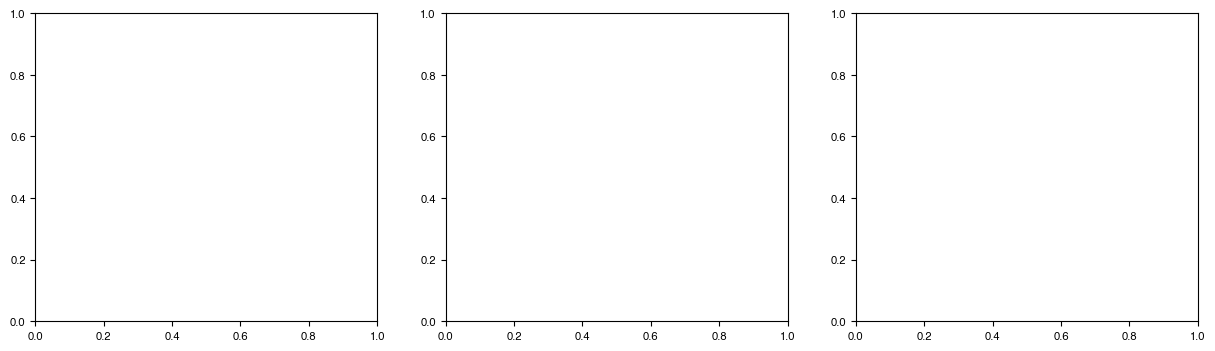

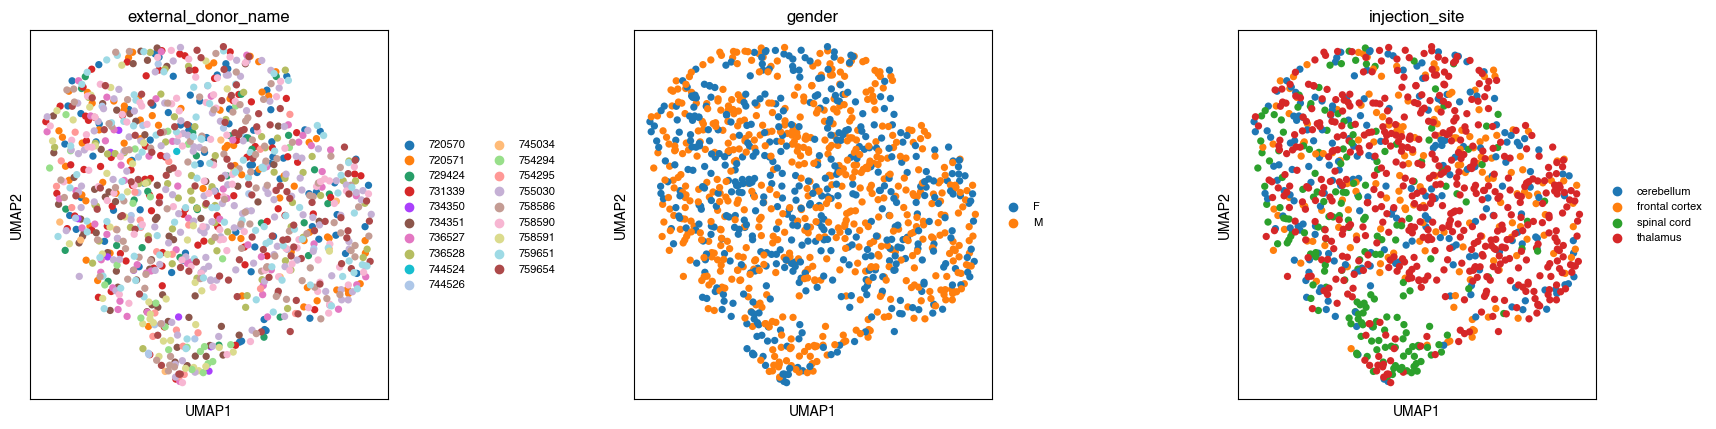

In [33]:
# UMAP Visualization
print("Creating UMAP visualization...")

# Compute neighbors and UMAP embedding
sc.pp.neighbors(adata_retro, use_rep=SCVI_LATENT_KEY, n_neighbors=50)
sc.tl.umap(adata_retro, random_state=210)

# Plot UMAP with metadata
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = sc.pl.umap(adata_retro, color=["external_donor_name", "gender", 'injection_site'], 
           ncols=3, show=False)
for a in ax:
    a.set_aspect('equal')
plt.tight_layout()
plt.show()

In [34]:
# Clean Injection Site Categories
print("Cleaning injection site categories...")

# Define categories and handle thalamus
cate_list = ["frontal cortex", 'cerebellum', "spinal cord", 'thalamus']
adata_retro.obs['injection_site'].replace('thalamus', np.nan, inplace=True)
adata_retro.obs["injection_site"] = pd.Categorical(
    adata_retro.obs["injection_site"],
    categories=cate_list[:-1],
    ordered=True
)
print("Injection site counts:")
print(adata_retro.obs['injection_site'].value_counts())

# Create color dictionary
cm = plt.cm.get_cmap('tab10')
default_colors = list(cm.colors)
col_list = default_colors[:3]
col_dict = {cate_list[i]: col_list[i] for i in range(len(cate_list))[:3]}
col_dict['others'] = 'white'

Cleaning injection site categories...
Injection site counts:
injection_site
cerebellum        210
spinal cord       184
frontal cortex    173
Name: count, dtype: int64


/scratch/fast/1595211/ipykernel_2967843/2379622490.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adata_retro.obs['injection_site'].replace('thalamus', np.nan, inplace=True)
/scratch/fast/1595211/ipykernel_2967843/2379622490.py:6: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata_retro.obs['injection_site'].r

Visualizing injection sites on UMAP...
Figure saving disabled: injection_site_umap (not saved)


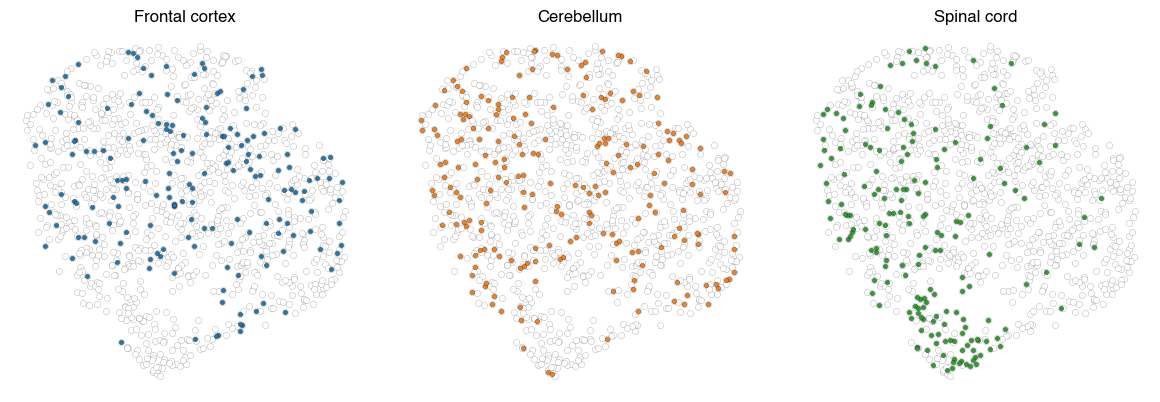

In [35]:
# Injection Site Visualization on UMAP
print("Visualizing injection sites on UMAP...")

# Highlighted UMAP plots for each injection site
umap_coords = adata_retro.obsm['X_umap']
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for m, k in enumerate(cate_list[:-1]):
    ax = axes[m]
    # Plot all cells in white
    ax.scatter(umap_coords[:, 0], umap_coords[:, 1], 
               color='white', s=20, alpha=1, label='_nolegend_',
               edgecolor='k', linewidth=.1)
    # Highlight cells from this injection site
    mask = adata_retro.obs['injection_site'] == k
    ax.scatter(umap_coords[mask, 0], umap_coords[mask, 1], 
               color=col_dict[k], s=10, alpha=1, label=k,
               edgecolor='k', linewidth=.2)
    ax.set_aspect('equal')
    ax.set_title(k.capitalize())
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.tight_layout()
save_figure("injection_site_umap")
plt.show()

In [36]:
# Add Normalized Layer and Save
print("Adding normalized layer (BN) and saving data...")

# Add normalized expression as a layer
adata_retro.layers["BN"] = model.get_normalized_expression(adata_retro)

# Save the processed data
savefilename = "/home/shuonan.chen/scratch_shuonan/retroseqdata/retro_BN_d4_1500genes.h5ad"
adata_retro.write(savefilename)
print(f"Data saved to: {savefilename}")

# Create a copy with normalized counts as X
adata_retro_BN = adata_retro.copy()
adata_retro_BN.X = adata_retro.layers['BN'].copy()
print("Created copy with BN as main layer")

Adding normalized layer (BN) and saving data...
Data saved to: /home/shuonan.chen/scratch_shuonan/retroseqdata/retro_BN_d4_1500genes.h5ad
Created copy with BN as main layer


Performing differential expression analysis between injection sites...


/allen/aind/scratch/shuonan.chen/conda_envs/torch_on_gpu_py310/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 1500 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


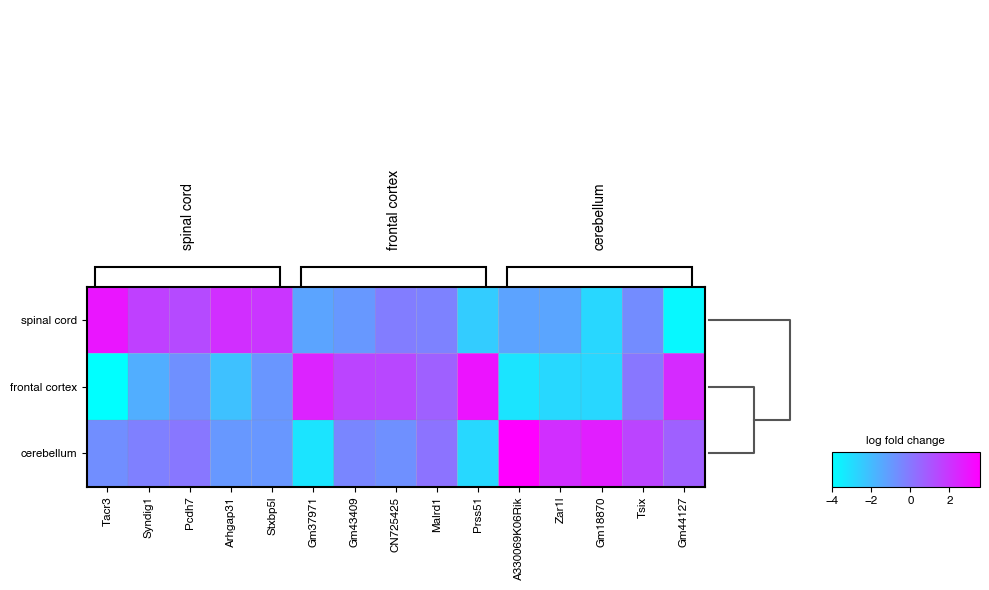

In [37]:
# Differential Expression Analysis
print("Performing differential expression analysis between injection sites...")

# Rank genes by group
sc.tl.rank_genes_groups(adata_retro_BN, groupby='injection_site', method='wilcoxon')

# Plot DE results as a matrix
fig, ax = plt.subplots(figsize=(10, 6))
sc.pl.rank_genes_groups_matrixplot(adata_retro_BN, 
                                  n_genes=5, cmap='cool',
                                  key="rank_genes_groups",
                                  groupby="injection_site", 
                                  values_to_plot="logfoldchanges",
                                  ax=ax, show=False)
plt.tight_layout()
# save_figure("de_matrix_default")
plt.show()

Creating enhanced DE visualization...
Figure saving disabled: de_matrix_enhanced (not saved)


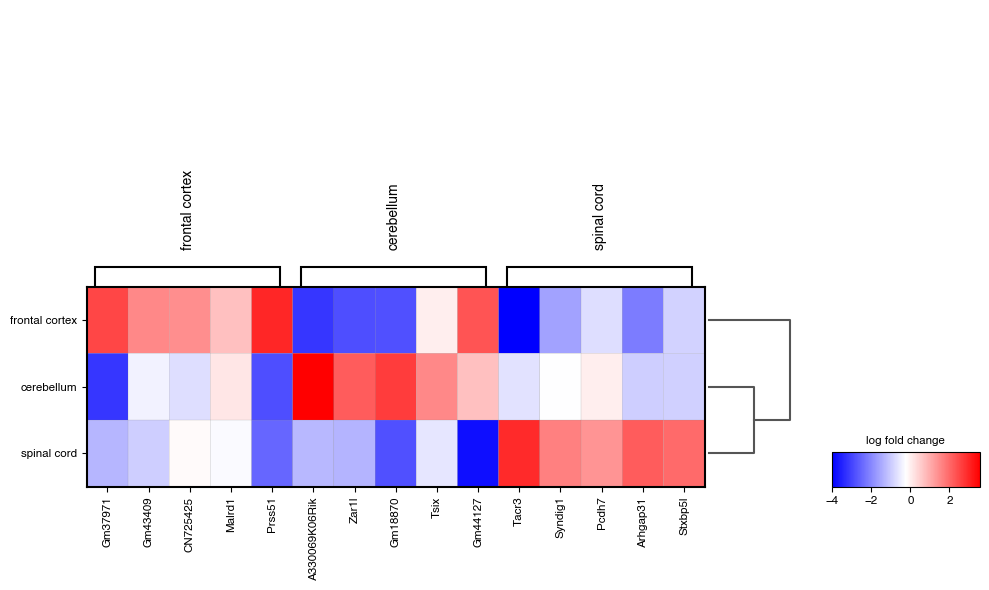


Top 5 DE genes for group 'frontal cortex':
['Gm37971' 'Gm43409' 'CN725425' 'Malrd1' 'Prss51']

Top 5 DE genes for group 'cerebellum':
['A330069K06Rik' 'Zar1l' 'Gm18870' 'Tsix' 'Gm44127']

Top 5 DE genes for group 'spinal cord':
['Tacr3' 'Syndig1' 'Pcdh7' 'Arhgap31' 'Stxbp5l']


In [38]:
# Reorder Categories and Enhance DE Visualization
print("Creating enhanced DE visualization...")

# Just reorder categories for better visualization
cate_list = ['frontal cortex', 'cerebellum', 'spinal cord', 'nan']
adata_retro_BN.uns['dendrogram_injection_site']['categories_ordered'] = cate_list[:-1]

# Plot DE results with better color scheme
T = 5  # Number of top genes to show
fig, ax = plt.subplots(figsize=(10, 6))
sc.pl.rank_genes_groups_matrixplot(adata_retro_BN, 
                                  n_genes=T, cmap='bwr',
                                  key="rank_genes_groups",
                                  groupby="injection_site", 
                                  values_to_plot="logfoldchanges",
                                  ax=ax, show=False)
plt.tight_layout()
save_figure("de_matrix_enhanced")
plt.show()

# Extract and print top DE genes
result = adata_retro_BN.uns['rank_genes_groups']
groups = result['names'].dtype.names
for group in groups:
    print(f"\nTop {T} DE genes for group '{group}':")
    print(result['names'][group][:T])

Performing PCA analysis...
Pre-scaling sum per cell: 1.0000
Post-scaling gene std mean: 0.9548, min: 0.3096, max: 0.9995
Figure saving disabled: pca_metadata (not saved)


/scratch/fast/1595211/ipykernel_2967843/4091676477.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


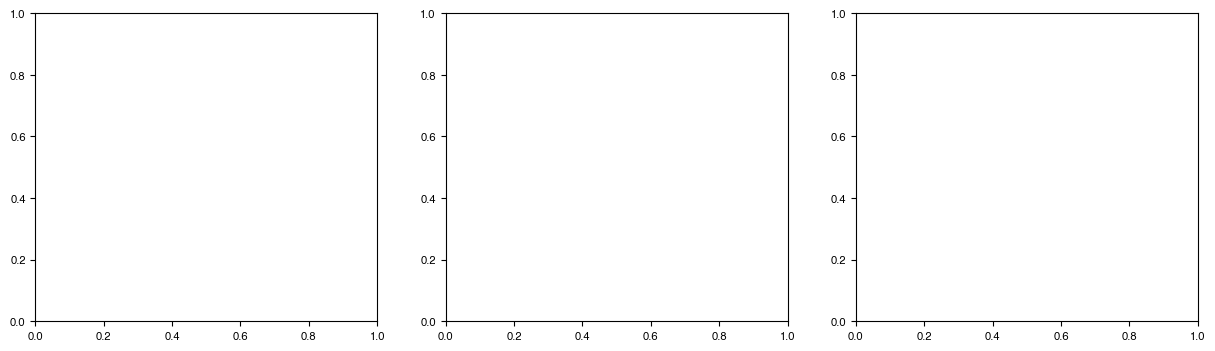

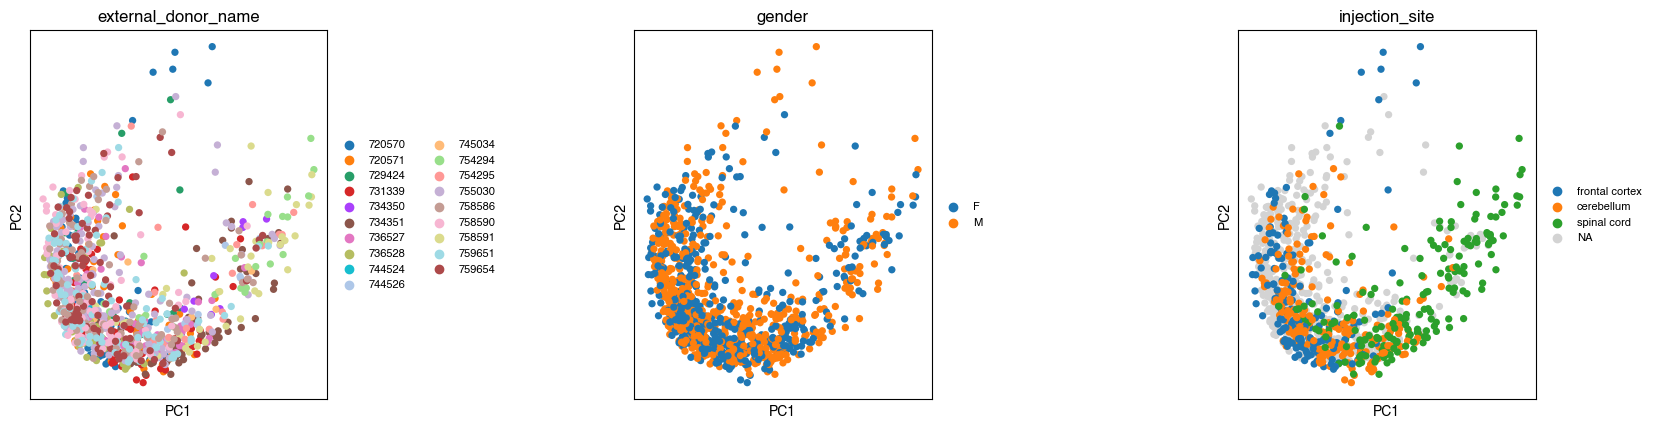

In [39]:
# PCA Analysis
print("Performing PCA analysis...")

# Store raw data before scaling
adata_retro_BN.raw = adata_retro_BN.copy()  # raw has total 1 gene per sample
print(f"Pre-scaling sum per cell: {np.mean(np.sum(adata_retro_BN.X, 1)):.4f}")

# Scale and run PCA
sc.pp.scale(adata_retro_BN, zero_center=True, max_value=10)
sc.pp.pca(adata_retro_BN, n_comps=50, svd_solver='arpack')

# Verify scaling
gene_std = np.std(adata_retro_BN.X, 0)
print(f"Post-scaling gene std mean: {np.mean(gene_std):.4f}, min: {np.min(gene_std):.4f}, max: {np.max(gene_std):.4f}")

# Plot PCA with metadata
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = sc.pl.pca(adata_retro_BN, color=['external_donor_name', "gender", 'injection_site'], show=False)
for a in ax:
    a.set_aspect('equal')
plt.tight_layout()
save_figure("pca_metadata")
plt.show()

Visualizing key genes on PCA...
Figure saving disabled: pca_key_genes (not saved)


/scratch/fast/1595211/ipykernel_2967843/2076336180.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


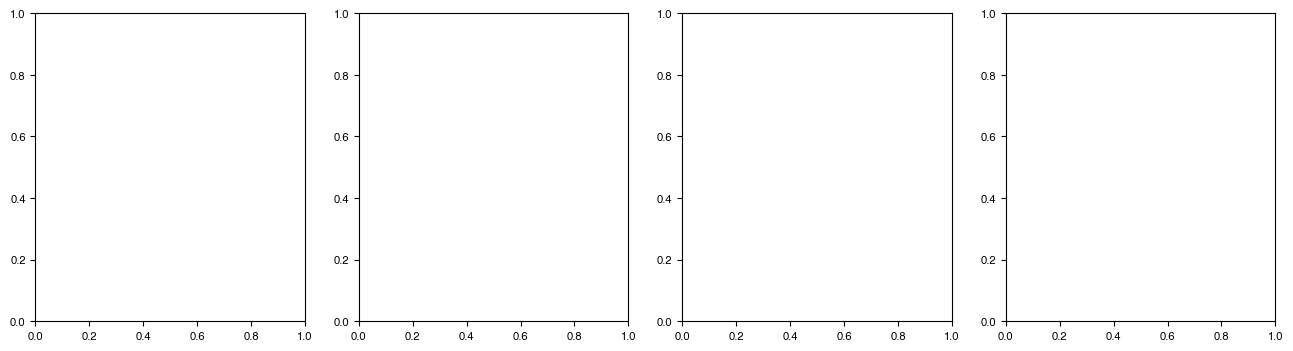

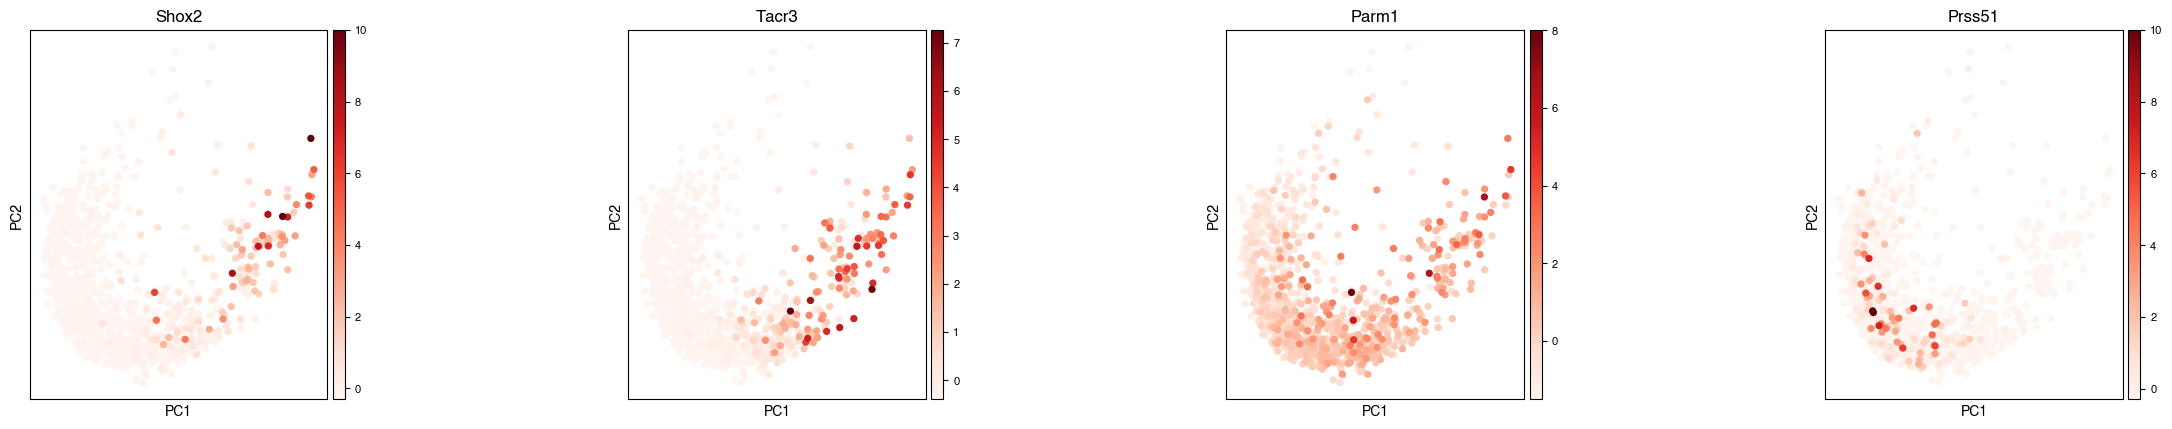

In [40]:
# Visualize Key Genes on PCA
print("Visualizing key genes on PCA...")

key_genes = ['Shox2', 'Tacr3', 'Parm1', 'Prss51']
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax = sc.pl.pca(adata_retro_BN, color=key_genes, cmap='Reds', show=False, use_raw=False)
for a in ax:a.set_aspect('equal')
plt.tight_layout()
save_figure("pca_key_genes")
plt.show()

In [41]:
# Prepare for Data Integration
print("Preparing for data integration with snRNA-seq...")

adata_sc = sc.read_h5ad(os.path.join(SNRNA_DATA_DIR, "snRNAseq_LCNE_BN_d4_1-5k.h5ad"))


# Create copy with BN layer as main layer
adata_sc_BN = adata_sc.copy()
adata_sc_BN.X = adata_sc.layers['BN'].copy()
adata_sc_BN.raw = adata_sc_BN.copy()

# Load pseudocluster information
print("Loading pseudocluster information...")
arc_path = '/home/shuonan.chen/scratch_shuonan/scripts/LC_NE_dataintegration/snRNAseq_only/cellID_pc_0722.csv'
arcinfo = pd.read_csv(arc_path)
arcinfo = arcinfo.set_index('cellID')
adata_sc_BN.obs['pc'] = arcinfo['pseudoclusters'].reindex(adata_sc_BN.obs.index)
print(f"Added pseudocluster scores to {adata_sc_BN.n_obs} cells")

# Free memory
del(adata_sc)

Preparing for data integration with snRNA-seq...
Loading pseudocluster information...
Added pseudocluster scores to 4895 cells


In [42]:
# Prepare Retroseq Data for Integration
print("Preparing retroseq data for integration...")

# Reset to normalized counts and filter to reference genes
adata_retro_BN.X = adata_retro_BN.raw.X.copy()
adata_retro_BN = adata_retro_BN[:, adata_sc_BN.var_names].copy()

# Rename 'gender' to 'sex' for consistency with reference
adata_retro_BN.obs.rename(columns={'gender': 'sex'}, inplace=True)

# Check normalization
print(f"Retroseq sum per cell: {np.mean(np.sum(adata_retro_BN.X, 1)):.4f}")
print(f"Reference sum per cell: {np.mean(np.sum(adata_sc_BN.X, 1)):.4f}")

Preparing retroseq data for integration...
Retroseq sum per cell: 1.0000
Reference sum per cell: 1.0000


In [43]:
# Scale Retroseq Data Using Reference Statistics
print("Scaling retroseq data using reference statistics...")

# Get reference statistics
X = adata_sc_BN.X.copy()
ref_means = X.mean(axis=0)           # shape (n_genes,)
ref_stds = X.std(axis=0, ddof=0)    # shape (n_genes,)

# Manually re-scale the query to the same statistics
Xq = adata_retro_BN.X.toarray() if hasattr(adata_retro_BN.X, "toarray") else adata_retro_BN.X
Xq = (Xq - ref_means) / ref_stds
Xq = np.clip(Xq, -10, 10)  # if you used max_value=10 on the reference
adata_retro_BN.X = Xq

# Scale and perform PCA on reference
sc.pp.scale(adata_sc_BN, zero_center=True, max_value=10)
sc.pp.pca(adata_sc_BN, n_comps=50, svd_solver='arpack')
sc.pp.neighbors(adata_sc_BN)

Scaling retroseq data using reference statistics...


In [44]:
# Ingest Retroseq Data into Reference PCA
print("Ingesting retroseq data into reference PCA space...")

# Perform ingest
sc.tl.ingest(adata_retro_BN, adata_sc_BN, embedding_method='pca', inplace=True, obs='leiden')
adata_retro_BN.uns["leiden_colors"] = adata_sc_BN.uns["leiden_colors"]

# Transfer pseudocluster scores using k nearest neighbors
print("Transferring pseudocluster scores...")
k = 100
nbrs = NearestNeighbors(n_neighbors=k).fit(adata_sc_BN.obsm['X_pca'])
dists, idxs = nbrs.kneighbors(adata_retro_BN.obsm['X_pca'])

ref_scores = adata_sc_BN.obs['pc'].values
weights = 1 / (dists + 1e-12)
weights /= weights.sum(axis=1, keepdims=True)

adata_retro_BN.obs['pc'] = (ref_scores[idxs] * weights).sum(axis=1)
print("Pseudocluster scores transferred")

Ingesting retroseq data into reference PCA space...


/allen/aind/scratch/shuonan.chen/conda_envs/torch_on_gpu_py310/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Transferring pseudocluster scores...
Pseudocluster scores transferred


Visualizing integration results...
Figure saving disabled: integration_results (not saved)


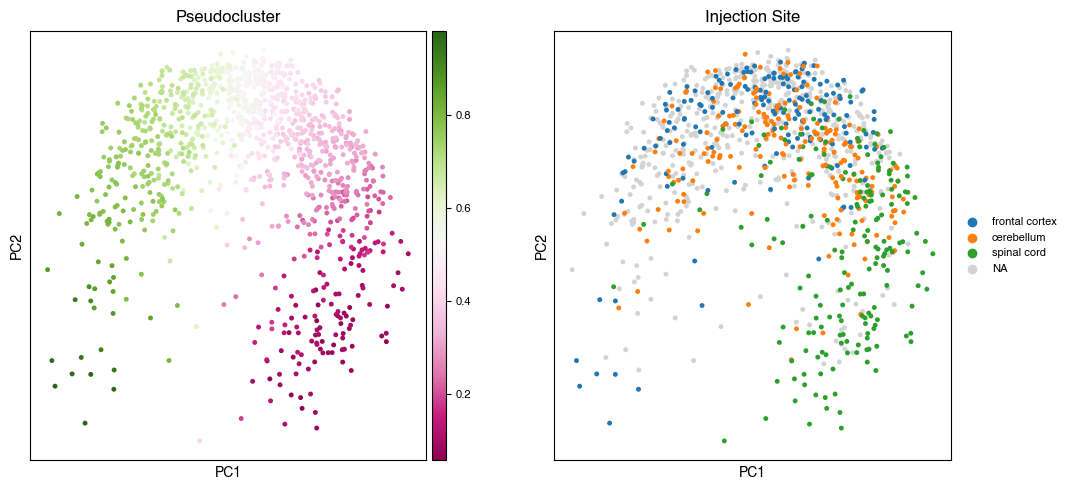

In [45]:
print("Visualizing integration results...")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1) Pseudocluster
sc.pl.pca(
    adata_retro_BN,
    ax=axes[0],
    color='pc',
    title='Pseudocluster',
    show=False,
    s=50,
    cmap='PiYG'
)
axes[0].set_aspect('equal')

# 2) Injection Site
sc.pl.pca(
    adata_retro_BN,
    ax=axes[1],
    color='injection_site',
    title='Injection Site',
    show=False,
    s=50,
    cmap='PiYG'
)
axes[1].set_aspect('equal')

plt.tight_layout()
save_figure("integration_results")
plt.show()


Concatenating datasets for joint analysis...


/scratch/fast/1595211/ipykernel_2967843/2567172826.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Figure saving disabled: joint_pca (not saved)


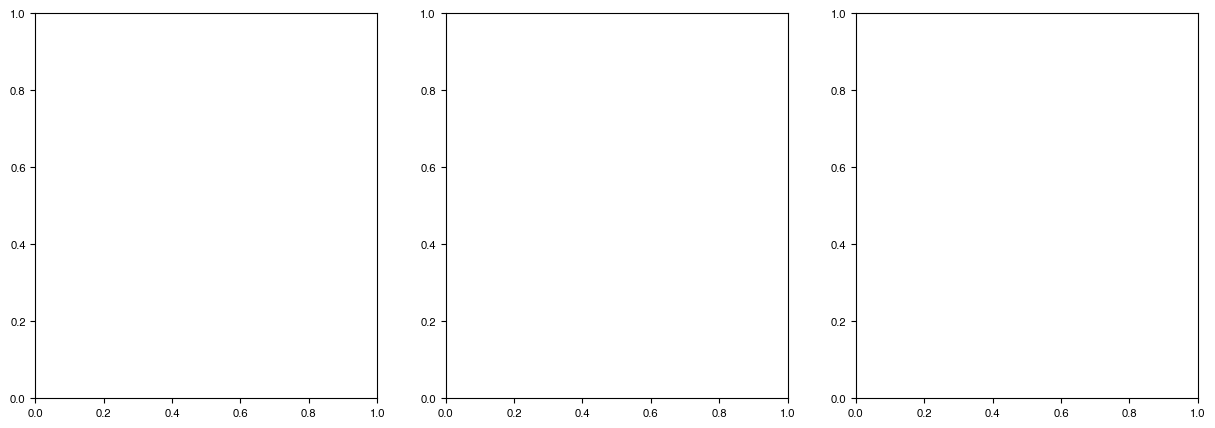

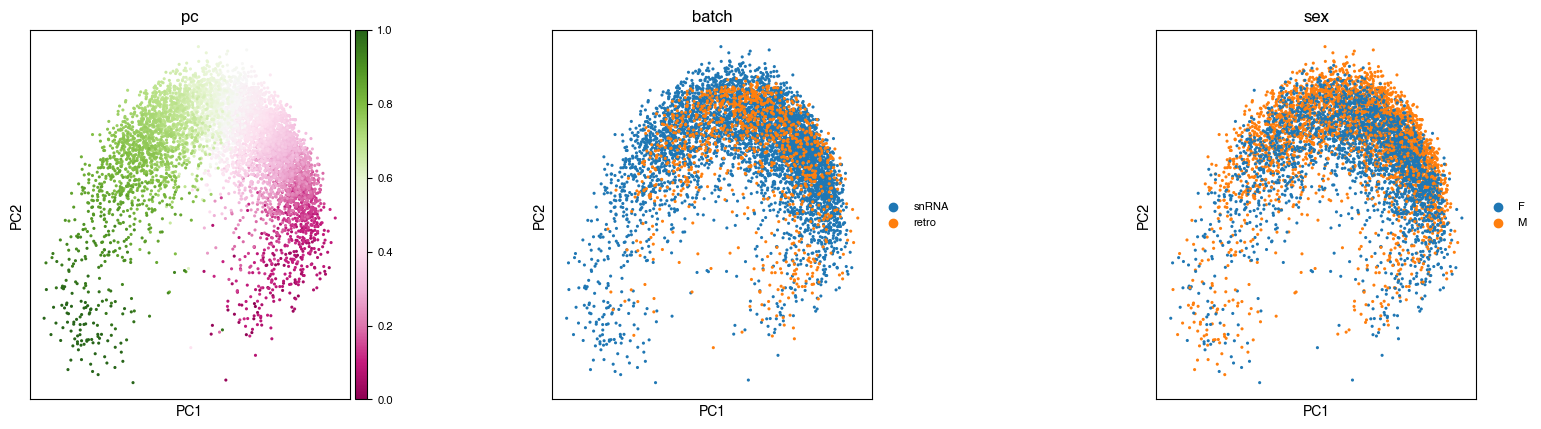

In [46]:
# Concatenate Datasets for Joint Analysis
print("Concatenating datasets for joint analysis...")

# Concatenate with batch label
adata_concat = anndata.concat(
    [adata_sc_BN, adata_retro_BN], 
    label="batch", 
    keys=["snRNA", "retro"]
)

# Add injection site info (NA for snRNA cells)
adata_concat.obs['injection_site'] = list(np.repeat('NA', len(adata_sc_BN))) + list(adata_retro_BN.obs['injection_site'])

# Visualize joint PCA
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax = sc.pl.pca(adata_concat, color=['pc', 'batch', 'sex'], cmap='PiYG', show=False)
for a in ax:
    a.set_aspect('equal')
plt.tight_layout()
save_figure("joint_pca")
plt.show()

Visualizing injection sites in joint PCA space...
Figure saving disabled: injection_site_pca (not saved)


/scratch/fast/1595211/ipykernel_2967843/2329965212.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('tab10')


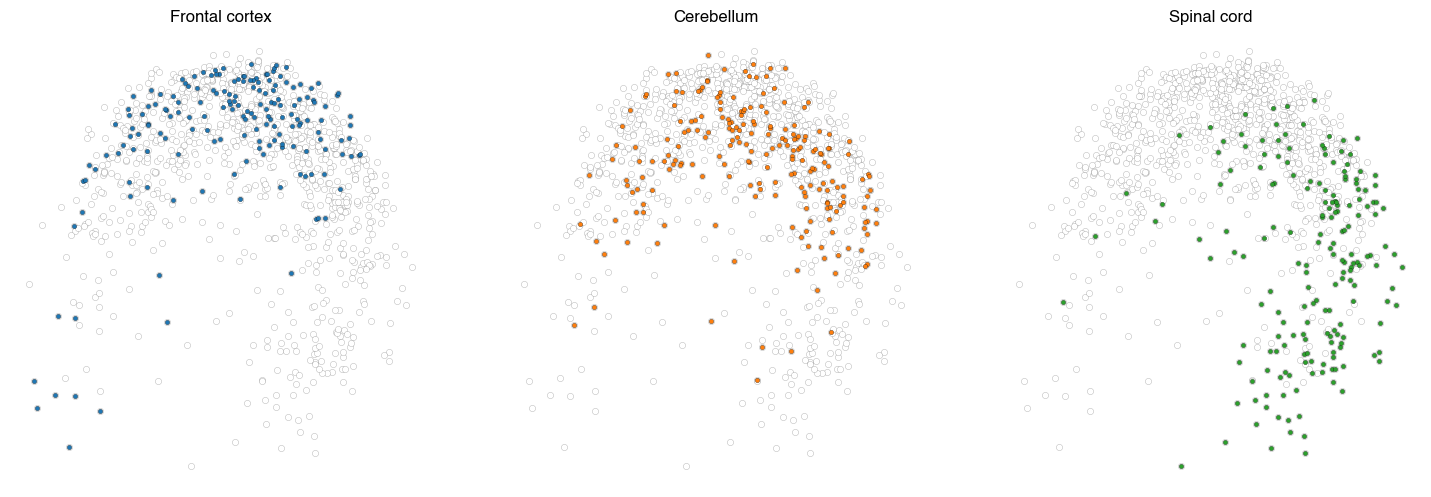

In [47]:
# Visualize Injection Sites in Joint PCA
print("Visualizing injection sites in joint PCA space...")

# Setup colors
cate_list = ['frontal cortex', 'cerebellum', 'spinal cord', 'NA']
cm = plt.cm.get_cmap('tab10')
default_colors = list(cm.colors)
col_list = default_colors[:3]
col_dict = {cate_list[i]: col_list[i] for i in range(len(cate_list))[:3]}
col_dict['others'] = 'white'

# Extract retroseq cells only
adata_subset = adata_concat[adata_concat.obs['batch'] == 'retro'].copy()
pca_coords = adata_subset.obsm['X_pca']

# Create plots for each injection site
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for m, k in enumerate(cate_list[:-1]):
    ax = axes[m]
    # Plot all cells in white
    ax.scatter(pca_coords[:, 0], pca_coords[:, 1], 
               color='white', s=20, alpha=1, label='_nolegend_',
               edgecolor='k', linewidth=.1)
    # Highlight cells from this injection site
    mask = adata_subset.obs['injection_site'] == k
    ax.scatter(pca_coords[mask, 0], pca_coords[mask, 1], 
               color=col_dict[k], s=10, alpha=1, label=k,
               edgecolor='k', linewidth=.2)    
    ax.set_aspect('equal')
    ax.set_title(k.capitalize())
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.tight_layout()
save_figure("injection_site_pca")
plt.show()

In [48]:
# Analysis Summary
print("Analysis complete! All visualizations have been saved to:", fig_path)
print("\nSummary of analysis:")
print(f"- Analyzed {adata_retro.n_obs} retroseq cells with {adata_retro.n_vars} genes")
print(f"- Integrated with {adata_sc_BN.n_obs} snRNA-seq cells")
print(f"- Identified differentially expressed genes between {len(cate_list)-1} injection sites")
print(f"- Transferred pseudocluster scores from snRNA-seq to retroseq data")
print(f"- Generated visualizations for data integration and spatial mapping")

Analysis complete! All visualizations have been saved to: /home/shuonan.chen/scratch_shuonan/fig_making_LCNE/july_2025/retroseq/

Summary of analysis:
- Analyzed 1089 retroseq cells with 1500 genes
- Integrated with 4895 snRNA-seq cells
- Identified differentially expressed genes between 3 injection sites
- Transferred pseudocluster scores from snRNA-seq to retroseq data
- Generated visualizations for data integration and spatial mapping
